In [1]:
import numpy as np
from hrro_env_norm import HRROenv
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.algorithms.ppo import PPOConfig
from auxiliary_classes import (
    Membrane,
    Solution,
    DesignParameters,
    OperationParameters,
)

from ray.rllib.utils.framework import try_import_tf
tf2, tf, _ = try_import_tf()
tf2.enable_eager_execution()

/home/femoto/python-environments/ray/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
restored_policy = Algorithm.from_checkpoint(checkpoint="/home/femoto/ray_results/PPO/HRRO_CS3_lstm_finetune/PPO_HRROenv_5b82c_00008_8_lr=0.0005,lstm_cell_size=128,max_seq_len=30,num_sgd_iter=3,sgd_minibatch_size=512,train_batch_size=30000_2023-07-26_00-02-58/checkpoint_000200")

2023-09-13 00:42:21,523	WARNING algorithm_config.py:596 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
2023-09-13 00:42:21,765	WARNING algorithm_config.py:723 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Algorithm.train()`. Instead, you will have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2023-09-13 00:42:23,426	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(pid=441281) /home/femoto/python-environments/ray/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
(pid=441281)   logger.warn(f"Overriding environment {new_spec.id} already in registry.")
(pid=441276) /home/femoto/python-environments/ray/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: U

In [5]:
restored_policy.evaluate()

{'evaluation': {'episode_reward_max': 0.032318850901773395,
  'episode_reward_min': -0.003180317617057651,
  'episode_reward_mean': 0.013147094737204778,
  'episode_len_mean': 150.4,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [0.005098256396354663,
    0.03177901819456659,
    0.013634055354728626,
    0.008745919901303712,
    -0.003180317617057651,
    0.004565320822721536,
    0.032318850901773395,
    0.00536008578544645,
    0.024242333592878917,
    0.008907424039331539],
   'episode_lengths': [131, 145, 167, 116, 176, 157, 171, 159, 162, 120]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.36690429979133266,
   'mean_inference_ms': 2.24735940068384,
   'mean_action_processing_ms': 0.18290999903620228,
   'mean_env_wait_ms': 44.76918424160493,
   'mean_env_render_ms': 0.0},
  'num_faulty_episodes': 0,
  'connector_metrics': {'Ob

In [328]:
config = {
            'membrane': Membrane().membrane_xus180808_double(),
            'solution': Solution(),
            'design': DesignParameters.Nijhuis_BIA(),
            'operation': OperationParameters()
        }

env = HRROenv(config)
obs, _ = env.reset()

# Previous action and reward as part of the input
init_prev_a = prev_a = dict({
        'flowrates_pgtime': np.array([0, 0, 0]),
        'end_semibatch': 0,
        'end_process': 0
    })
init_prev_r = prev_r = 0.0

# range(2) b/c h- and c-states of the LSTM.
init_state = state = restored_policy.get_policy().model.get_initial_state()

terminated = truncated = False

/home/femoto/python-environments/ray/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Lists to add the different parameter values at each time step.

In [329]:
temperature = env.process.temperature #
concentration = env.process.concentration_feed[0] #
tank_volumes = [env.process.feed_tank_current_volume] #
mean_concentrations = [] #
time = [env.process.time] #
supply_pressures = [env.process.pressure_supply] #
recirc_pressures = [env.process.pressure_recirc] #
flow_rates_supply = [0] #
flow_rates_recirc = [0]
permeate_flow_rates = [] #
pg_time = [0] #
semibatch_end = [0] #
process_end = [0] 
rewards = [0] #
SEC = [] #

get_purge = False
get_semibatch = True

length = 0

In [330]:
while terminated == False and truncated == False:
    a, state_out, _ = restored_policy.compute_single_action(
        observation=obs,
        state=state,
        prev_action=prev_a,
        prev_reward=prev_r,
        explore=False,
        policy_id="default_policy"
    )
    # Send the computed action `a` to the env.
    obs, reward, terminated, truncated, info = env.step(a)

    state = state_out
    prev_a = a
    prev_r = reward

    # Add parameter values to list
    if get_purge:
        SEC.append(env.process.SEC_Total_current)
        pg_time.append(a['flowrates_pgtime'][2])
        semibatch_end.append(int(0))
        flow_rates_recirc.append(int(0))
        get_semibatch = True
        if env.process.feed_tank_current_volume < 700:
            process_end.append(a['end_process'])
        else:
            process_end.append(int(0))

    length += 1
    tank_volumes.append(env.process.feed_tank_current_volume)
    time.append(env.process.time)
    supply_pressures.append(env.process.pressure_supply)
    recirc_pressures.append(env.process.pressure_recirc)
    flow_rates_supply.append(a['flowrates_pgtime'][0])
    rewards.append(reward)

    if env.process.phase == 'semibatch':
        if not get_purge:
            flow_rates_recirc.append(a['flowrates_pgtime'][1])
            semibatch_end.append(int(0))
            pg_time.append(int(0))
            process_end.append(int(0))
        get_purge = False


    elif env.process.phase == 'batch':
        if get_semibatch:
            semibatch_end.append(a['end_semibatch'])
            get_semibatch = False
        else:
            semibatch_end.append(int(0))
        flow_rates_recirc.append(a['flowrates_pgtime'][1])
        process_end.append(int(0))
        pg_time.append(int(0))
    
    elif env.process.phase == 'purge&refill':
        flow_rates_recirc.append(a['flowrates_pgtime'][1])
        mean_concentrations.append(env.process.concentrations.mean(axis=0)[0])
        permeate_flow_rates.append(env.process.calculate_permeate_flow_rate())
        pg_time.append(int(0))
        semibatch_end.append(int(0))
        process_end.append(int(0))
        get_purge = True
        
    



In [331]:
print(f"temperature: {temperature - 273.15}")
print(f"concentration: {concentration}")

temperature: 29.920818339883965
concentration: 5.846153846153846


In [332]:
from matplotlib import pyplot as plt
import numpy as np

mean_concentrations = np.array(mean_concentrations)
permeate_flow_rates = np.array(permeate_flow_rates)
tank_volumes = np.array(tank_volumes)
time = np.array(time)
supply_pressures = np.array(supply_pressures)
recirc_pressures = np.array(recirc_pressures)
flow_rates_recirc = np.array(flow_rates_recirc)
flow_rates_supply = np.array(flow_rates_supply)
pg_time = np.array(pg_time)
rewards = np.array(rewards)
semibatch_end = np.array(semibatch_end)
process_end = np.array(process_end)
SEC = np.array(SEC)

Small arrays

In [333]:
print(env.process.phase)
print(f"Episode length: {length}")
print(f"Mean concentrations: {mean_concentrations}")
print(f"Mean cycle permeate flow rates: {permeate_flow_rates}")
print(f"SEC per cycle: {SEC}")
print(f"Total reward: {rewards.sum()}")

semibatch
Episode length: 165
Mean concentrations: [76.54591806 78.41228757 77.46316852 79.95615124 77.25083099]
Mean cycle permeate flow rates: [12.0595416  11.94073714 12.26318336 11.98875325 12.3885043 ]
SEC per cycle: [1.78230245 1.79074154 1.80153773 1.81860691 1.8542018 ]
Total reward: 0.03399516746582863


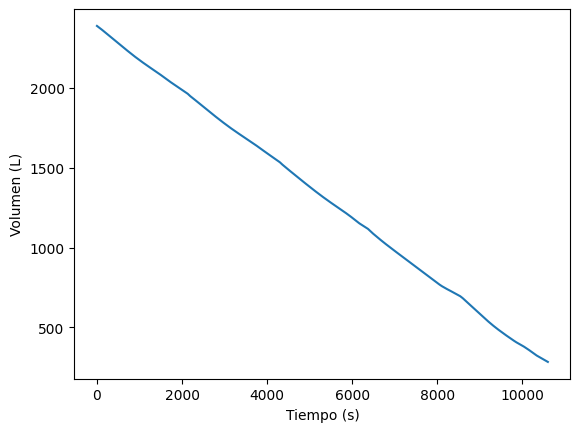

In [334]:
plt.xlabel('Tiempo (s)')
plt.ylabel('Volumen (L)')
plt.plot(time, tank_volumes)
plt.show()

In [335]:
print(tank_volumes[-1])

283.88804548797424


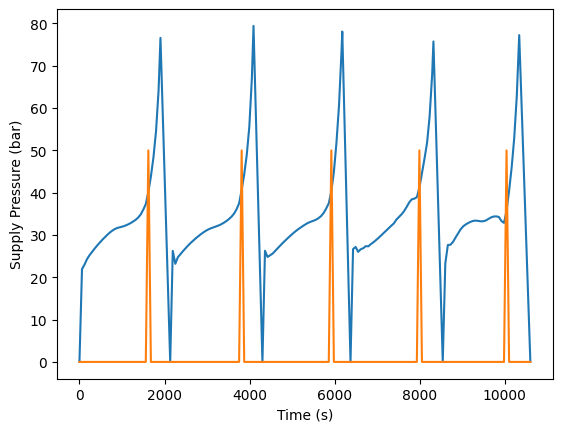

In [336]:
plt.xlabel('Time (s)')
plt.ylabel('Supply Pressure (bar)')
plt.plot(time, supply_pressures / 100)
plt.plot(time, semibatch_end * 50)
plt.show()

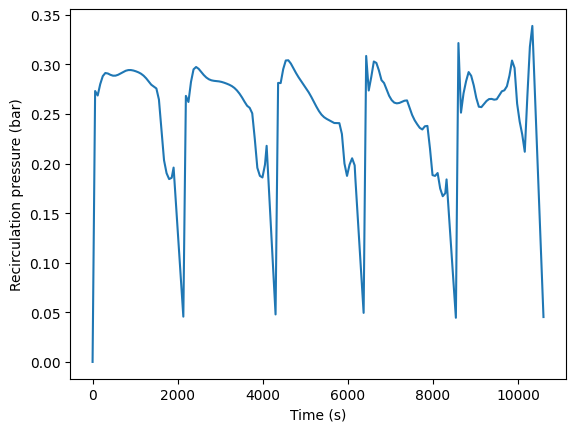

In [337]:
plt.xlabel('Time (s)')
plt.ylabel('Recirculation pressure (bar)')
plt.plot(time, recirc_pressures / 100)
plt.show()

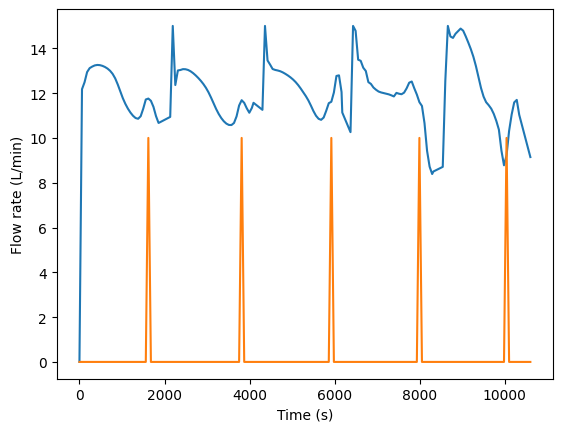

In [338]:
plt.xlabel('Time (s)')
plt.ylabel('Flow rate (L/min)')
plt.plot(time, flow_rates_supply * 60)
plt.plot(time, semibatch_end*10)
plt.show()

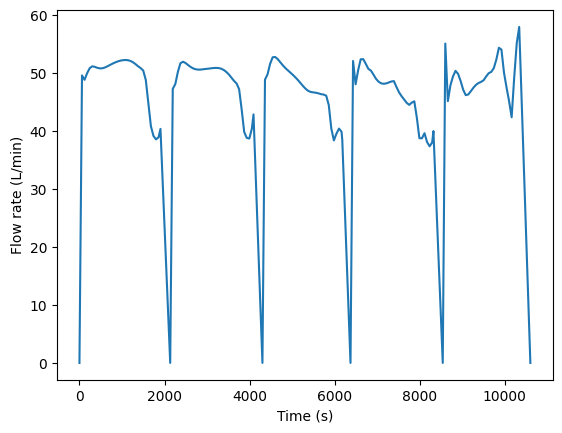

In [339]:
plt.xlabel('Time (s)')
plt.ylabel('Flow rate (L/min)')
plt.plot(time, flow_rates_recirc * 60)
plt.show()

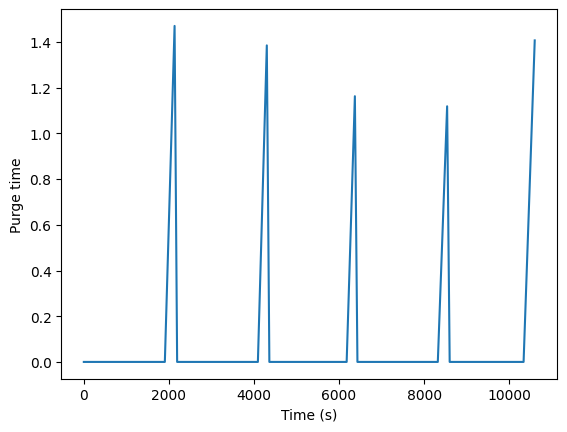

In [340]:
plt.xlabel('Time (s)')
plt.ylabel('Purge time')
plt.plot(time, pg_time)
plt.show()

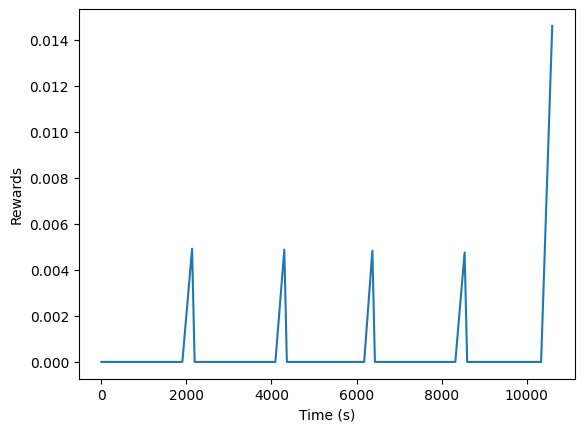

In [341]:
plt.xlabel('Time (s)')
plt.ylabel('Rewards')
plt.plot(time, rewards)
plt.show()